# Microscopy

<hr>

Objectives:
- Learn to analyze imaging data from microscopy.
- Learn how to use AI methods for microscopy ast the example of image segmentation for bacteria.

## Optical Microscopy

Optical microscopes use an optical system of lenses and visible light to generate a magnified image of a sample. The maximum attainable magnification in current setups, due to physical limitations, is about 1000x. While other microscopy techniques with higher magnification exist, our use-cases typically require that the sample, e.g., a bacterial culture, can proliferate while being observed. This is currently not the case with methods like [atomic force microscopy (AFM)](https://en.wikipedia.org/wiki/Atomic_force_microscopy) and [electron microscopy](https://en.wikipedia.org/wiki/Electron_microscope).

## Typical image processing problems
In the following we assume that an image, or a sequence of images, has been obtained by microscopy. Typical problems that one would like to solve are:
- Label: Detect the presence of particular objects in an image.
- Segment: Additionally, detect the position of the objects, e.g., via a bounding box or at the pixel-level (segmentation).
- Track: Additionally, track the objects along the sequence of images.

### Segmentation
In this lecture, we will focus on the segmentation problem at the example of bacterial cells.

The problem is often encoded as an image file and the output as a mask file. Both in pixel-accurate formats like `.tif`.

There are two different encodings for masks.
- Binary masks treat all foreground pixels as one class (0 = background, 1 = cell) and are suited for simple semantic segmentation when distinguishing foreground from background is sufficient.
- Instance masks give each object a unique label (0 = background, 1 = cell1, 2 = cell2, ...) and are preferred when object-level separation and counting are required, such as in crowded bacterial colonies.

We will study both problems: generating a binary mask and instance masks.


## Idealized Microscopy Data

We will start with idealized images of objects like they would be expected from bacteria visualized by microscopy.
For the purpose of simplicity, we first assume that our bacteria are disk-shaped, but can potentially overlap.

Let's install some libraries first.

In [3]:
# In case skimage, cv2, torch, or albumentations are not already installed, run:

# %pip install scikit-image
# %pip install opencv-python
# %pip install torch
# %pip install albumentations
# %pip install segmentation-models-pytorch
# %pip install pytorch-lightning

Below is code for a simple canvas we can draw on.

In [4]:
%%capture

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

import skimage
from skimage.draw import disk

class Canvas:
    """A simple canvas to draw shapes on."""
    x: int
    y: int
    img: np.ndarray

    def __init__(self, x: int, y: int) -> None:
        """Create a canvas.
        x: width
        y: length
        """
        self.x = x
        self.y = y
        self.img = np.zeros([x, y], dtype='int64')

    def disk(self, x: int, y: int, r: int) -> None:
        """Draw a disk.
        x, y: center
        r: radius
        """
        rr, cc = disk((x, y), r)
        self.img[rr, cc] = 1
    
    def show(self) -> None:
        """Show the canvas."""
        plt.imshow(self.img, cmap='gray')


Let's draw some circles. For the sake of challenge, two of them will overlap.

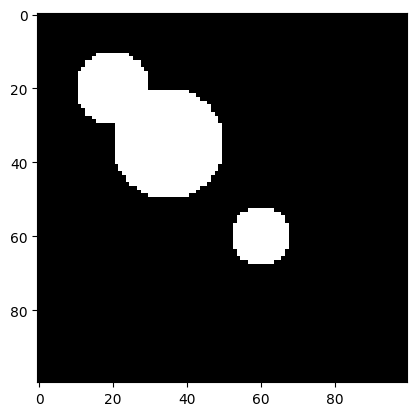

In [5]:
c: Canvas = Canvas(100, 100)
c.disk(20, 20, 10)
c.disk(35, 35, 15)
c.disk(60, 60, 8)
c.show()

## A solution: Distance Maxima and Watershedding

We now aim to perform an instance segmentation of this image. In particular, a so-called segmentation mask has the same dimensions as the original image, with each pixel value being the id of the object it belongs to.
The value 0 is reserved for the background.
In our case, 3 more values are to be assigned, 1, 2, and 3, corresponding to the 3 circle instances.

We solve this problem via a commonly used approach:
1. Generate a distance field to the background. The background is black and has value 0. Based on this, we assign each pixel a distance to the background.
2. Let the local maxima correspond to the centers of the objects.
3. Use the [Watershed algorithm](https://en.wikipedia.org/wiki/Watershed_(image_processing)) to assign the remaining pixels.

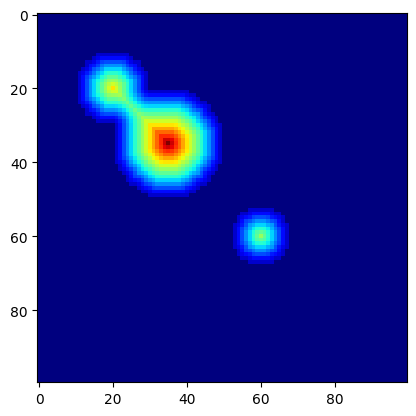

In [6]:
from scipy import ndimage as ndi

# Compute distance to 0-valued background
distance: np.ndarray = ndi.distance_transform_edt(c.img)
assert isinstance(distance, np.ndarray), "ensure type"

# Show the distance field as a heatmap
plt.imshow(distance, cmap=plt.cm.jet);

We next use `peak_local_max(...)` to find local maxima. The function has a parameter that specifies the locality: `footprint (ndarray of bools)` that is a mask for the local region within which to search for peaks at every point in `image`.

Number of cells: 3


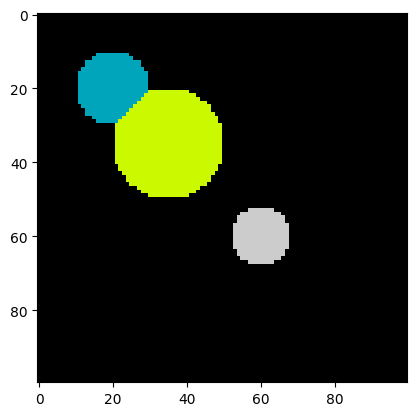

In [7]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


def find_watershed(
        img: np.ndarray,
        min_distance: int=10,
        footprint: np.ndarray=np.ones((10,10))
    ) -> tuple[np.ndarray, int]:
    """Find watershed segmentation of an image.
    
    Arguments:
        img: input image (2D array)
        min_distance: minimum distance between local maxima
        footprint: search area for local maxima
    
    Returns:
        labels: segmentation labels of pixels
        num_features: number of detected features
    """
    
    # Compute distance to background (background has value 0)
    distance: np.ndarray = ndi.distance_transform_edt(img)
    assert isinstance(distance, np.ndarray), "ensure type"

    # Get local (within footprint) maxima of the distance field
    # filter via minimum distance between maxima
    coords = peak_local_max(distance, labels=img, min_distance=min_distance, footprint=footprint)

    # Create segmentation labels for pixels
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, num_features = ndi.label(mask)
    return watershed(-distance, markers, mask=img), num_features

labels, num_features = find_watershed(c.img)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

## Noise

Let's increase the difficulty by adding some noise.
Clearly the type of noise depends on the microscopy setup.
Cell debris, inhomogeneous illumination, and dist on the lense or the measurement setup are only a few examples.
For the sake of simplicity, we add random pixels as an idealized noise source.

The function `np.random.random(shape)` returns random floats of shape `shape`, with each pixel being uniformly random in $[0, 1)$.

By multiplying a random value for a pixel by a constant $c$ (here, 1.1) and casting it to an `int`, we obtain that a pixel is `1` with probability $c - 1$ (here, 0.1) and `0`, otherwise.

Using this value as additive noise, we obtain:

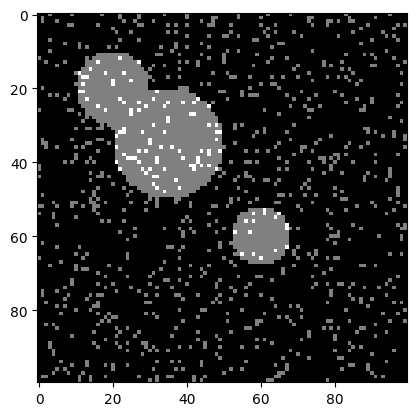

In [8]:
img = c.img + (1.1 * np.random.random(c.img.shape)).astype("int64")
plt.imshow(img, cmap=plt.cm.gray);

Let us try the watershed algorithm directly on the noisy image.

Number of cells: 44


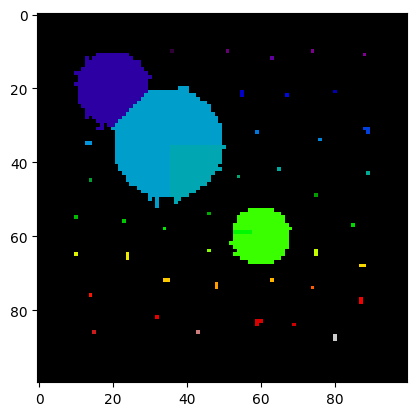

In [9]:
labels, num_features = find_watershed(img)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

The segmentation and the number of cells is clearly off.
All the single pixels are recognized as small cells.

We can do some image preprocessing to fix this.
One idea to remove small speckles is to erode them - letting the background grow into the object, and in a second step grow back the remaining objects.
The idea is that small speckles will be deleted in the first step, while large objects are almost not altered by the two consecutive steps.

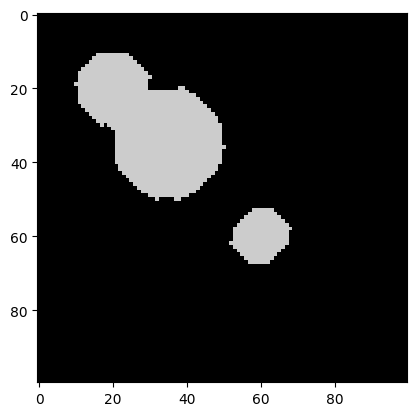

In [10]:
from scipy.ndimage import binary_erosion, binary_dilation

# shrink
img_new = binary_erosion(img, iterations=5)

# grow
img_new = binary_dilation(img_new, iterations=5)

plt.imshow(img_new, cmap=plt.cm.nipy_spectral);

It worked! All the speckles are gone. The objects have changed shape a bit, but this should not impede the watershed algorithm too much.

Let's try it on the preprocessed image.

Number of cells: 3


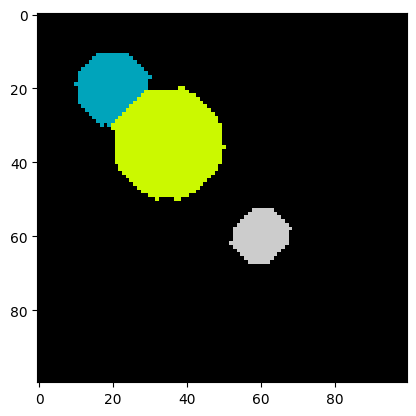

In [11]:
labels, num_features = find_watershed(img_new)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

Indeed, the segmentation is correct! We are ready for real data.

## Microscopic data of *E. coli*

We have uploaded an image of *E. coli* that we took in our lab with a microfluidic setup, an inverted microscope (40x lense), and a Raspberry Pi + camera.
The image `data/ecoli.png` is a crop of this image showing 3 bacteria.

The length of an *E. coli* is roughly 2 um, giving us a rough idea of the size of the crop as about 15 um x 15 um.

Since we do not expect any relevant information in the colors, we convert the image to gray-scale.

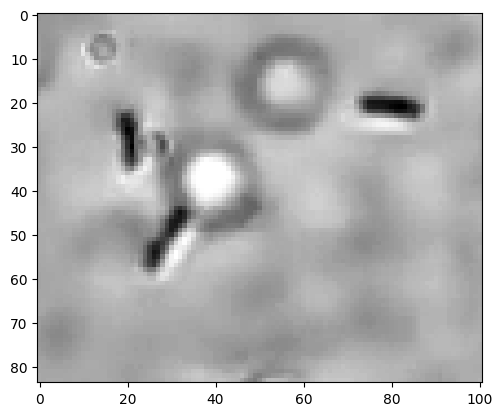

In [12]:
from skimage.color import rgb2gray

# Read image
img = skimage.io.imread("data/ecoli.png")

# Convert to grayscale
img = rgb2gray(img)

plt.imshow(img, cmap=plt.cm.gray);

We observe three _E. coli_ and one speckle that is either a small _E. coli_ or not further identified debris. For our purpose, we aim to not count this as a cell. The image also shows some circles that are unintended.

Following our previously successful procedure, let us threshold the image. After scaling pixel values to be within 0 and 255, we chose 180 as the object-background threshold. The choice was done by playing around with the threshold and observing the output.

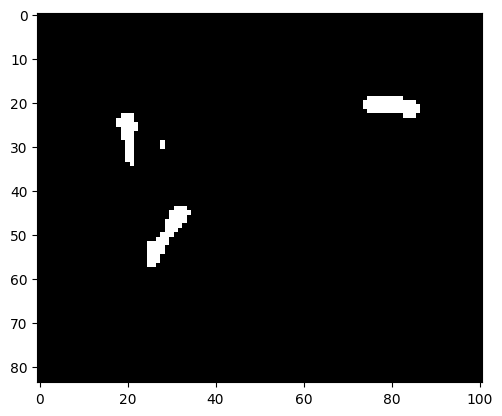

In [13]:
img_bin = np.zeros(img.shape).astype("int64")
mask = (img*255 < 180)
img_bin[mask] = 100
plt.imshow(img_bin, cmap=plt.cm.gray);

There is a small speckle observable that does not correspond to an *E. coli*. We can apply the erosion-dilation preprocessing that previously solved the problem with the pixel noise.

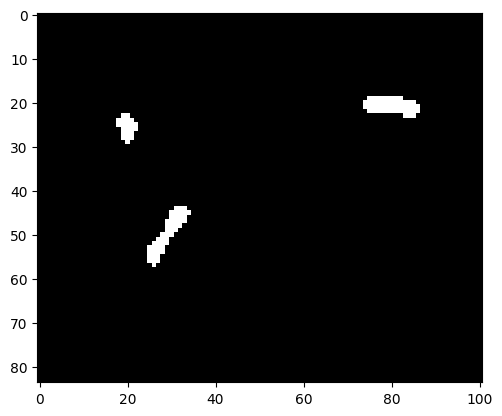

In [14]:
img_bin = binary_erosion(img_bin, iterations=1)
img_bin = binary_dilation(img_bin, iterations=1)

plt.imshow(img_bin, cmap=plt.cm.gray);

Indeed, the speckle is gone.

Number of cells: 3


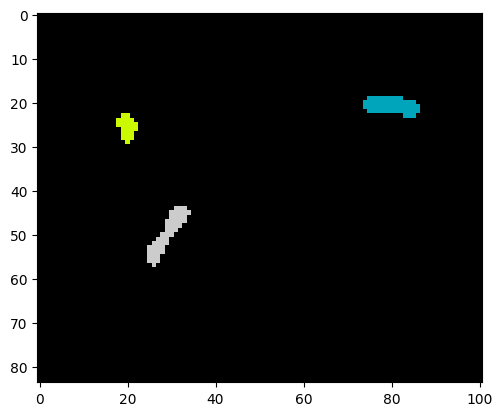

In [15]:
labels, num_features = find_watershed(img_bin, min_distance=10)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

As we see, a correct segmentation was obtained.

In [16]:
# Save image and mask
import os

os.makedirs("tmp_data", exist_ok=True)
skimage.io.imsave("tmp_data/image_0.png", (img*255).astype("uint8"))
skimage.io.imsave("tmp_data/mask_0.png", (img_bin*255).astype("uint8"))

## Intersection over Union (IoU)

Given an available true segmentation of an object, we may define the following measures:
- $A_\text{intersection}$ as the size of the intersection area of the true and predicted object.
- $A_\text{union}$ as the size of the union area of the true and predicted object.

Then, IoU is defined as $A_\text{intersection} / A_\text{union}$.
The measure is between 0 and 1, with 1 signifying identity of predicted and true object.

## Challenging microscopic data

We further increase the challenge to images with more bacteria.

For that purpose we will use the [dataset by Scherr et al.](https://data.niaid.nih.gov/resources?id=ZENODO_6497714).
Please download it and move it into the main folder, so that you see the folder `microbeSEG_dataset` next to the notebook.

Let us view a (normalized) example image from the test dataset.

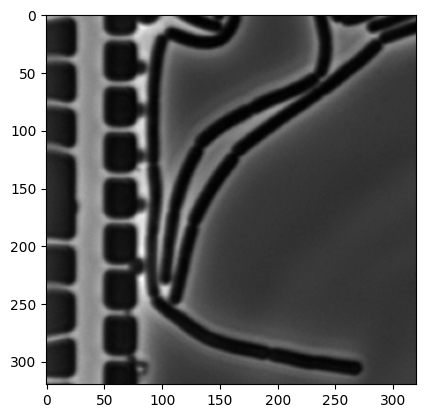

In [17]:
# Dataset path
dataset_path = Path("microbeSEG_dataset") / "30min-man_15min-pre"

# Load an example image
file_path = dataset_path / "train" / "img_000.tif"
img = skimage.io.imread(file_path)

# Normalize to range 0-255
img = img / np.max(img) * 255

plt.imshow(img, cmap=plt.cm.gray);

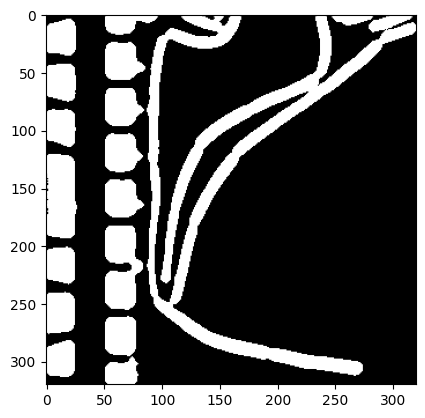

In [18]:
img_bin = np.zeros(img.shape).astype("int64")
mask = (img < 50)
img_bin[mask] = 100

img_bin = binary_erosion(img_bin, iterations=2)
img_bin = binary_dilation(img_bin, iterations=2)
plt.imshow(img_bin, cmap=plt.cm.gray);

On the right center of the image, it is already visible that some of the background has been detected as objects. You can play around with the preprocessing parameters and the threshold of `50`, but no satisfying parameters can be found.

Indeed, subsequent segmentation with watershedding yields wrong results.

Number of cells: 97


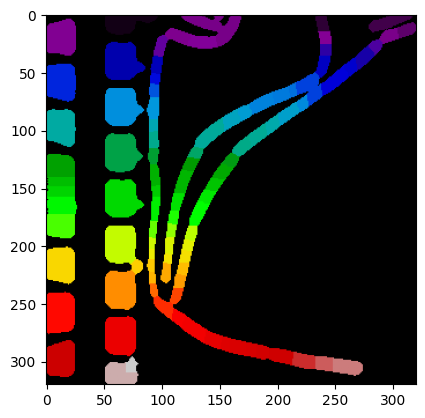

In [19]:
labels, num_features = find_watershed(img_bin, min_distance=10, footprint=np.ones([10,10]))
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

The number of cells has clearly been overestimated. Playing round with the parameters of `find_watershed` may slightly improve the result, but the ground truth is not (easily) obtained.

While including different pre-processing steps, such as normalizing and segmenting on local crops, may solve the problem of a global threshold and yield the correct result, finding the right pipeline can be challenging and time consuming. We explore a different approach in the following section.

### Deep learning for segmentation

Neural networks (NNs) have shown impressive performance on multiple problems. We will use one to demonstrate the use of NNs for segmenting microscopic images. While several libraries for bacteria / cell segmentation exist, we will use a more general segmentation library in the following. The purpose of this is twofold:
- Currently available specialized libraries are limited in several aspects, making it difficult to adapt them to our needs. Typically one tries them all and picks the best for one's need.
- They come as black boxes, and using them provides little insight into which algorithmic steps are used.
- Several of the libraries are outdated, not running on up-to-date Python libraries.

The classical approach to training NNs to solve segmentation is via supervised learning, training the NN with tuples of an input image `img` and a corresponding mask `mask`. This requires the availability of labeled masks. Luckily the [dataset by Scherr et al.](https://data.niaid.nih.gov/resources?id=ZENODO_6497714) comes with such masks. 

While coding your own Pytorch NNs is clearly possible, we skip this step and use the library [segmentation_models](https://github.com/qubvel-org/segmentation_models.pytorch) which comes with a set of standard NN architectures for segmentation as well as the possibility to download pre-trained weights.

For example, a model with the Unet architecture is simply created via:
```python
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=OUT_CLASSES,            # model output channels (number of classes in your dataset)
)
```


In [20]:
import segmentation_models_pytorch as smp

OUT_CLASSES = 1

Here, we will use a different architecture. We will train our model on the data within `microbeSEG_dataset/30min-man_15min-pre/train/`. The following code was adapted from an example [segmentation of cars](https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb).


In [21]:
# Code adapted from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb

import os
import cv2
import re

import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

DATA_DIR = Path("microbeSEG_dataset") / "30min-man_15min-pre"
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"

The files have names composed of a prefix, an intermediate `_`, and a number with leading `0`s.
Let's code a function that returns the images with a certain prefix. We need this to seperate `img` from `mask` files; and ensure they are ordered by increasing numbers.

In [22]:
def prefix_files(dir: str | Path, prefix: str) -> list[str]:
    """Get list of files in directory with given prefix, sorted by number suffix."""
    pattern = prefix + r'_(\d+)'

    # Extract filename and number
    img_files: list[tuple[str, int]] = []
    
    for filename in os.listdir(dir):
        match = re.match(pattern, filename)
        if match:
            img_files.append((filename, int(match.group(1))))
    
    # sort by number
    img_files.sort(key=lambda x: x[1])
    return [os.path.join(dir, f[0]) for f in img_files]

prefix_files(TRAIN_DIR, "img")

['microbeSEG_dataset/30min-man_15min-pre/train/img_000.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_001.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_004.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_005.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_008.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_009.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_011.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_012.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_014.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_015.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_017.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_020.tif',
 'microbeSEG_dataset/30min-man_15min-pre/train/img_021.tif']

We next code a class that allows us to retrieve data from an image directory. The class has some subtle features that will be import for training an NN-based segmenter:
- It extracts an image and returns a classification according to `CLASSES` per pixel. We can specify with a parameter `classes` which classes an existing mask file contains.
- It provides the possibility to apply an augmentation to the stored images and masks. Augmentations are image transformations. The augmentation is specified with `augmentation`.

Further, we code a simple image/mask visualization function.

In [23]:
# Code adapted from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb

class Dataset(BaseDataset):
    """Read images, apply augmentation transformations.

    Args:
        images_dir (str): path to images folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline
            (e.g. flip, scale, etc.)

    """

    CLASSES = [
        "cell",
        "background",
    ]

    def __init__(
        self,
        images_dir: Path | str,
        classes: tuple | list=(),
        augmentation=None,
        augmentation_factor: int=10,
    ):
        """Create the dataset."""
        self.images_fps = prefix_files(images_dir, "img") * augmentation_factor
        self.masks_fps = prefix_files(images_dir, "mask") * augmentation_factor

        # convert str names to class values on masks
        # e.g. ['cell'] -> [1]
        self.class_values = [self.CLASSES.index(c.lower()) for c in classes]

        self.augmentation = augmentation

    def __getitem__(self, i):
        """Read image and mask."""

        image = cv2.imread(self.images_fps[i])
        mask = cv2.imread(self.masks_fps[i], flags=2)

        assert image is not None, f"Image not found {self.images_fps[i]}"
        assert mask is not None, f"Mask not found {self.masks_fps[i]}"

        # Extract certain classes from mask (e.g. cells)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype("float32")
        
        # Invert mask: 1 = segment, 0 = background
        mask = 1 - mask

        # Apply augmentation to image and mask
        if self.augmentation is not None:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # Change data format from HWC (height-width-channel) to CHW (channel-height-width)
        # as required by PyTorch
        return image.transpose(2, 0, 1), mask.transpose(2, 0, 1)

    def __len__(self) -> int:
        """Number of images in the dataset, including augmentations."""
        return len(self.images_fps)
    

def visualize(**image_masks) -> None:
    """Plot images in one row."""
    n: int = len(image_masks)
    plt.figure(figsize=(7, 4))
    for i, (name, image) in enumerate(image_masks.items()):
        plt.subplot(1, n, i + 1)
        plt.title(" ".join(name.split("_")).title())
        if name == "image":
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image)
    plt.show()

Let's inspect one of the image/mask pairs and show it without any augmentation.

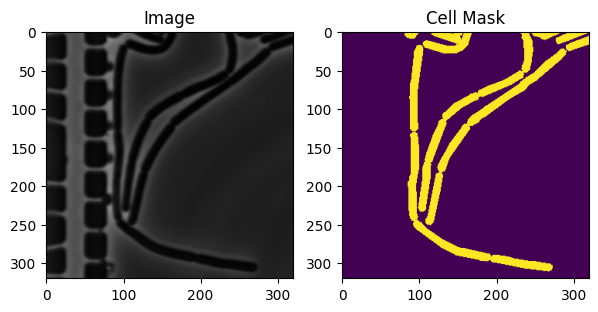

In [24]:
dataset = Dataset(TRAIN_DIR, classes=["cell"])

# Show one of them
image, mask = dataset[0]
visualize(
    image=image,
    cell_mask=mask.squeeze(),
)

Since there are relatively few images in the dataset, we will augment our dataset by applying transformations. This also ensures that a certain generalizability of the trained model to different environmental conditions.

Again, let's inspect some the image/mask pairs.

/Users/mfuegger/Github/Biodisco/computational_bioengineering/venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


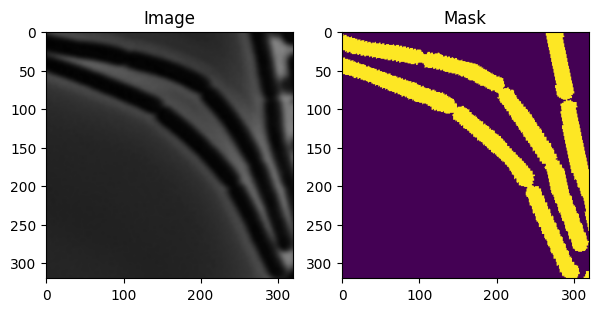

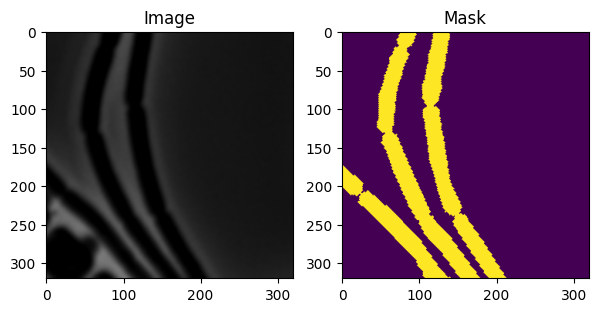

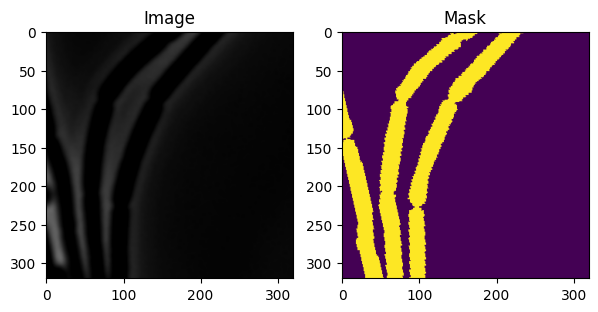

In [25]:
# Code adapted from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb

# training set images augmentation
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            scale_limit=(0.8, 1.2), rotate_limit=(-45, 45), shift_limit=(-0.05, 0.05), p=1, border_mode=0
        ),
        A.PadIfNeeded(min_height=320, min_width=320, p=1),
        A.RandomCrop(height=320, width=320, p=1),
        A.GaussNoise(p=0.01),
        # A.Perspective(p=0.1),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(min_height=384, min_width=480, p=1),
    ]
    return A.Compose(test_transform)

# Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    TRAIN_DIR,
    augmentation=get_training_augmentation(),
    classes=["cell"],
)

# Check 3 augmented samples for the same image
for i in range(3):
    image, mask = augmented_dataset[0]
    visualize(image=image, mask=mask.squeeze())

We are now in the position to code the data loaders for training, validation, and testing.

In [26]:
CLASSES = ["cell"]

train_dataset = Dataset(
    TRAIN_DIR,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
)

valid_dataset = Dataset(
    VAL_DIR,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
)

test_dataset = Dataset(
    TEST_DIR,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0);

print(f"Training dataset has size: {len(train_dataset)}")

Training dataset has size: 130


In [27]:
# Code adapted from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb

# Some training parameters
EPOCHS = 1 # 60
T_MAX = EPOCHS * len(train_loader)

class BacteriaModel(pl.LightningModule):
    def __init__(self, arch: str, encoder_name: str, in_channels: int, out_classes: int, nn_model=None, **kwargs):
        super().__init__()
        # create nn_model if none is provided
        if nn_model is None:
            self.nn_model = smp.create_model(
                arch,
                encoder_name=encoder_name,
                in_channels=in_channels,
                classes=out_classes,
                **kwargs,
            )
        else:
            self.nn_model = nn_model

        # preprocessing parameters for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metrics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image
        image = (image - self.mean) / self.std
        mask = self.nn_model(image)
        return mask

    def shared_step(self, batch, stage: str):
        image, mask = batch

        # Required shape: (batch_size, num_channels, height, width)
        # For grayscale:  (batch_size, 1, height, width)
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32)
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() == 1.0 and mask.min() == 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # convert mask values to probabilities, then
        prob_mask = logits_mask.sigmoid()
        # map to 0, 1
        pred_mask = (prob_mask > 0.5).float()

        # Return metrics
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate metrics
        loss = [x["loss"].item() for x in outputs]
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Per image IoU
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # Dataset IoU
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        # Show the metrics in the progress bar
        self.log_dict(metrics, prog_bar=True, enable_graph=True)

    def on_train_epoch_end(self) -> None:
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()


    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self) -> None:
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self) -> None:
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

We will use an architecture that is called [Feature Pyramid Network (FPN)](https://openaccess.thecvf.com/content_cvpr_2017/html/Lin_Feature_Pyramid_Networks_CVPR_2017_paper.html).

In [28]:
# train a new model if none exists
if "bacterial_model" not in globals():
    print("Starting with a fresh model.")
    bacterial_model = BacteriaModel(
        arch="FPN",
        encoder_name="resnext50_32x4d",
        in_channels=3,
        out_classes=OUT_CLASSES,
        nn_model=None
    )

    # train it
    trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)
    trainer.fit(
        bacterial_model,
        train_dataloaders=train_loader,
        val_dataloaders=valid_loader,
    )

Starting with a fresh model.
2025-12-06 16:09:29,573 [INFO] 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
2025-12-06 16:09:29,583 [INFO] GPU available: True (mps), used: True
2025-12-06 16:09:29,573 [INFO] 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
2025-12-06 16:09:29,583 [INFO] GPU available: True (mps), used: True
2025-12-06 16:09:29,583 [INFO] TPU available: False, using: 0 TPU cores
2025-12-06 16:09:29,583 [INFO] TPU available: False, using: 0 TPU cores


/Users/mfuegger/Github/Biodisco/computational_bioengineering/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ nn_model │ FPN      │ 25.6 M │ train │     0 │
│ 1 │ loss_fn  │ DiceLoss │      0 │ train │     0 │
└───┴──────────┴──────────┴────────┴───────┴───────┘

Trainable params: 25.6 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 25.6 M                                                                                               
Total estimated model params size (MB): 102                                                                        
Modules in train mode: 210                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/Users/mfuegger/Github/Biodisco/computational_bioengineering/venv/lib/python3.12/site-packages/pytorch_lightning/tr
ainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve 
performance.

/Users/mfuegger/Github/Biodisco/computational_bioengineering/venv/lib/python3.12/site-packages/pytorch_lightning/tr
ainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to 
improve performance.

2025-12-06 16:09:47,183 [INFO] `Trainer.fit` stopped: `max_epochs=1` reached.


And finally run validation and test.

In [29]:
# run validation dataset
valid_metrics = trainer.validate(bacterial_model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

Output()

[{'valid_per_image_iou': 0.1196909174323082, 'valid_dataset_iou': 0.1359257996082306}]


In [30]:
# run test dataset
test_metrics = trainer.test(bacterial_model, dataloaders=test_loader, verbose=False)
print(test_metrics)

Output()

/Users/mfuegger/Github/Biodisco/computational_bioengineering/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


[{'test_per_image_iou': 0.06317619979381561, 'test_dataset_iou': 0.05443083494901657}]


Let's check the results on some image/mask/prediction tuples.

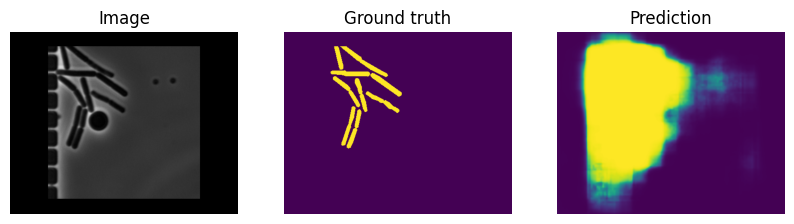

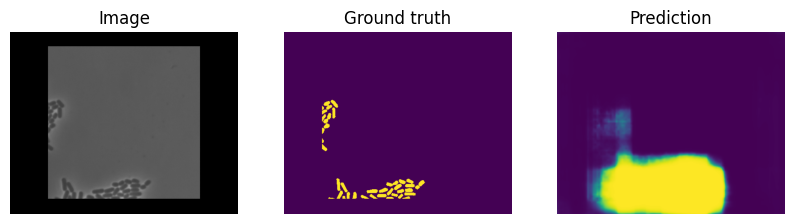

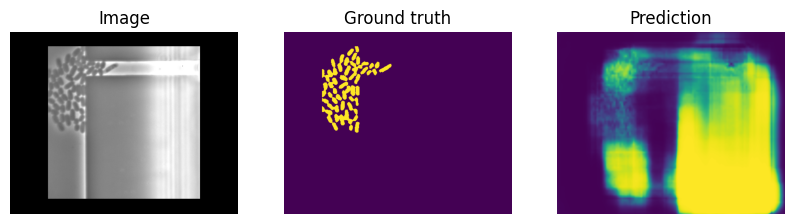

In [31]:
images, masks = list(next(iter(test_loader)))
with torch.no_grad():
    bacterial_model.eval()
    logits = bacterial_model(images)
pr_masks = logits.sigmoid()

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx >= 3:
        break

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze())
    plt.title("Prediction")
    plt.axis("off")
    plt.show()

### Limitations of generalizability

Equipped with a trained model, let's try to segment an image from a different setup and dataset.

(np.float64(-0.5), np.float64(319.5), np.float64(319.5), np.float64(-0.5))

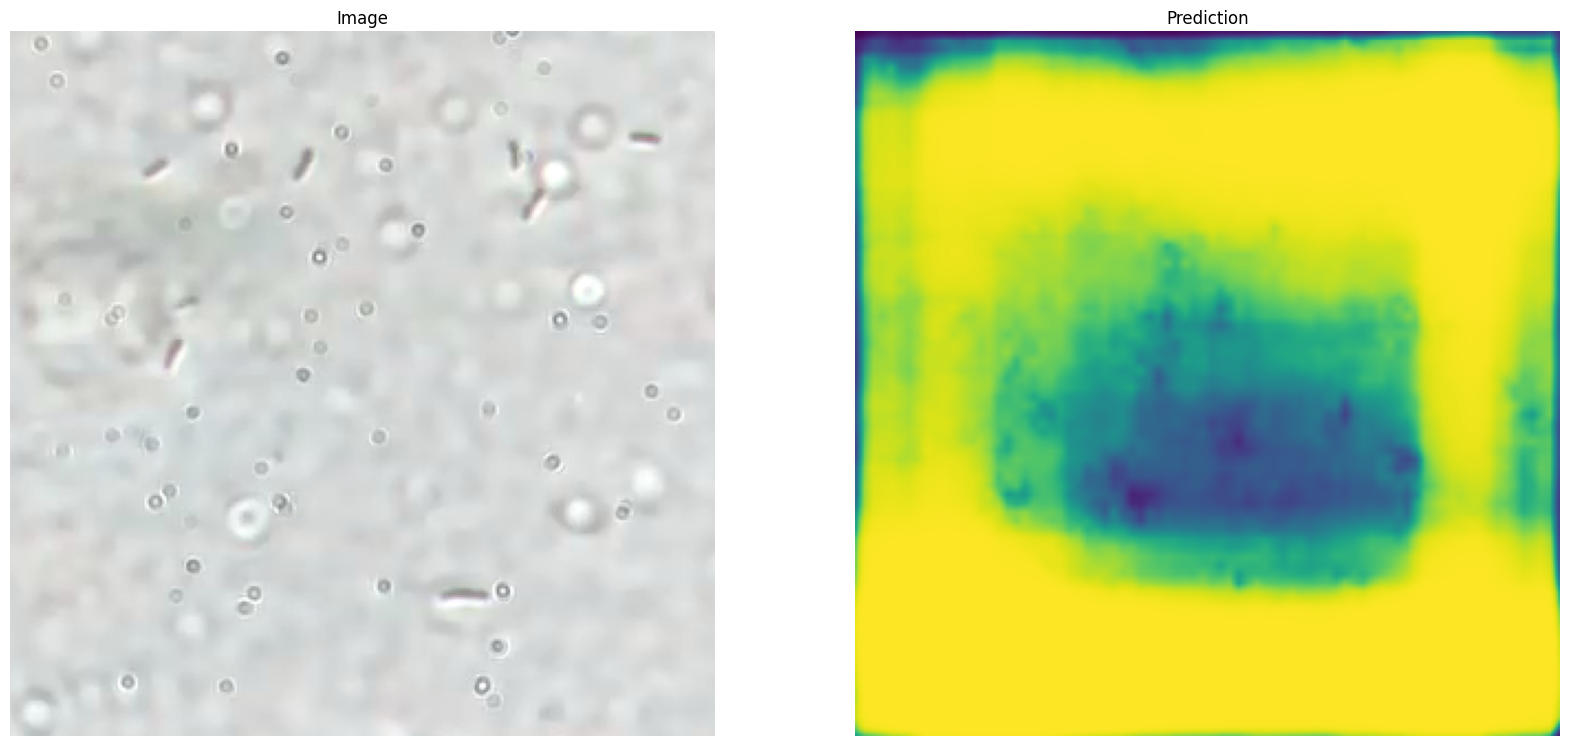

In [32]:
assert bacterial_model is not None, "train model first"

image = cv2.imread("data/ecoli_full.png")
transformation = A.RandomCrop(height=320, width=320, p=1.0)
image = transformation(image=image)["image"]

image = image.transpose(2, 0, 1)
with torch.no_grad():
    bacterial_model.eval()
    logits = bacterial_model(torch.Tensor(image))
pr_mask = logits.sigmoid()

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(image.transpose(1, 2, 0))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pr_mask.numpy().squeeze())
plt.title("Prediction")
plt.axis("off")

While some correlation can be observed, the segmentation is clearly not good.

## Dedicated Cell Segmenters

We will look into `omnipose` as an example for a dedicated cell segmenter.

[Omnipose](https://github.com/kevinjohncutler/omnipose) is a specialized tool for segmenting bacteria and other cells. It extends Cellpose with improvements for bacterial segmentation, including better handling of elongated cells and tight clusters.

In [33]:
# Install omnipose (uncomment to install)
# %pip install omnipose
# %pip install cellpose
# %pip install scipy

2025-12-06 16:10:13,866 [INFO] ** TORCH MPS version installed and working. **
2025-12-06 16:10:13,867 [INFO] >>>> using GPU (MPS)
2025-12-06 16:10:13,868 [WARNING] pretrained model /Users/mfuegger/.cellpose/models/cpsam not found, using default model
2025-12-06 16:10:13,867 [INFO] >>>> using GPU (MPS)
2025-12-06 16:10:13,868 [WARNING] pretrained model /Users/mfuegger/.cellpose/models/cpsam not found, using default model
2025-12-06 16:10:16,988 [INFO] >>>> loading model /Users/mfuegger/.cellpose/models/cpsam
2025-12-06 16:10:16,988 [INFO] >>>> loading model /Users/mfuegger/.cellpose/models/cpsam
2025-12-06 16:10:17,731 [INFO] processing grayscale image with (300, 300) HW
2025-12-06 16:10:17,731 [INFO] processing grayscale image with (300, 300) HW


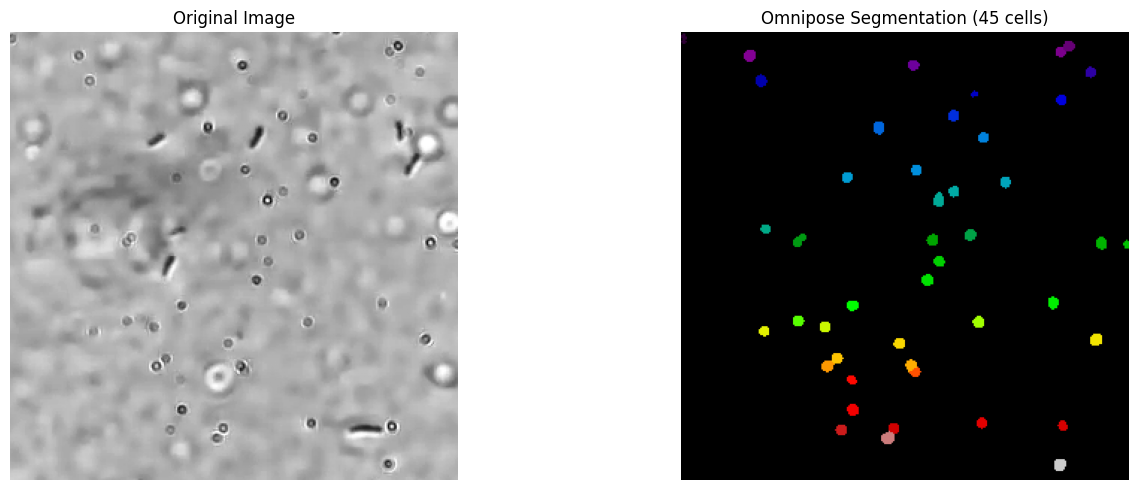

Detected 45 cells


In [34]:
# monkey patching for omnipose compatibility
import scipy
import numpy.fft as _npfft

# Monkey-patch missing attributes
scipy.fft = _npfft.fft
scipy.ifft = _npfft.ifft

import omnipose
from cellpose import models
from skimage import io
from skimage.color import rgb2gray

# Load the E. coli image
img = io.imread("data/ecoli_full.png")
transformation = A.CenterCrop(height=300, width=300, p=1.0)
img = transformation(image=img)["image"].astype(np.float32)

# Convert to grayscale if needed
if img.ndim == 3:
    img = rgb2gray(img).astype(np.float32)

# Normalize the image
img_normalized = (img * 99).astype(np.float32)

# Initialize model
model = models.CellposeModel(gpu=True, pretrained_model='bact_phase_omni')

# Run segmentation
masks, flows, styles = model.eval(
    img_normalized,
)

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masks, cmap='nipy_spectral')
plt.title(f"Omnipose Segmentation ({masks.max()} cells)")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Detected {masks.max()} cells")

In [ ]:
from matplotlib.pyplot import imsave
import napari

# image layer
img_ecoli = io.imread("data/ecoli_full.png")

# create the training directory if it does not exist
training_path = Path("tmp_ecoli") / "training"
os.makedirs(training_path, exist_ok=True)

# mask layer
# load if file exists
if 
labels_layer_data = np.zeros(img_ecoli.shape[:2], dtype=np.uint16)  

# start viewer
viewer = napari.Viewer()
viewer.add_image(img_ecoli, name="Microscopy")
viewer.add_labels(labels_layer_data, name='Ecoli')

# Draw and the Ecoli mask, making sure the label value is incremented by 1 for each new cell.
# Then do NOT close the viewer, but run the next cell to save the mask.

KeyError: 'TIF'

/Users/mfuegger/Github/Biodisco/computational_bioengineering/venv/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: bacteria_masks.tif is a low contrast image
  return func(*args, **kwargs)


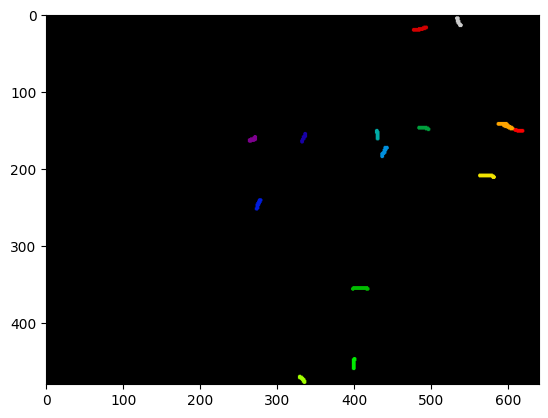

In [43]:
from skimage.io import imsave

labels = viewer.layers['Masks'].data
plt.imshow(labels, cmap=plt.cm.nipy_spectral)

# save
imsave('bacteria_masks.tif', labels.astype('uint16'))

In [36]:
# Train on E. coli dataset

from omnipose.utils import normalize_field
from cellpose import models, io
from pathlib import Path
import numpy as np

# Prepare training data
train_images = []
train_masks = []

# Load training data from the dataset
dataset_path = Path("microbeSEG_dataset") / "30min-man_15min-pre"
train_dir = dataset_path / "train"

# Get image and mask files
img_files = prefix_files(train_dir, "img")
mask_files = prefix_files(train_dir, "mask")

print(f"Loading {len(img_files)} training images...")

for img_path, mask_path in zip(img_files[:20], mask_files[:20]):  # Use subset for demo
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, flags=2)
    
    if img is not None and mask is not None:
        # Convert to grayscale if needed
        if img.ndim == 3:
            img = rgb2gray(img)
        
        # Normalize image
        img = (img * 255).astype(np.uint8)
        
        # Convert mask to instance segmentation format (each cell gets unique ID)
        from scipy import ndimage as ndi
        labeled_mask, num_features = ndi.label(mask > 0)
        
        train_images.append(img)
        train_masks.append(labeled_mask)

print(f"Loaded {len(train_images)} training images")

# Initialize Omnipose model (not Cellpose)
model = models.CellposeModel(gpu=True, model_type='bact_phase_omni')

# Train the model with Omnipose
# Note: This requires significant computational resources and time
# For a full training run, increase n_epochs (e.g., 500-1000)
print("Starting Omnipose training...")

model.train(
    train_data=train_images,
    train_labels=train_masks,
    channels=[0, 0],  # grayscale
    save_path='./models/',  # where to save model
    n_epochs=100,  # number of epochs (increase for better results)
    learning_rate=0.1,
    weight_decay=0.0001,
    model_name='ecoli_omnipose',
    omni=True  # Enable Omnipose-specific training features
)

print("Training complete! Model saved to ./models/ecoli_omnipose")

Loading 13 training images...
Loaded 13 training images
2025-12-06 16:10:24,777 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-12-06 16:10:24,778 [INFO] ** TORCH MPS version installed and working. **
2025-12-06 16:10:24,778 [INFO] >>>> using GPU (MPS)
2025-12-06 16:10:28,186 [INFO] >>>> loading model /Users/mfuegger/.cellpose/models/cpsam
Starting Omnipose training...


AttributeError: 'CellposeModel' object has no attribute 'train'

---
**License**: © 2025 Matthias Függer and Thomas Nowak. Licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).